In [37]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.unicode_minus'] = False


pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

    stock_holding
    2019/06/20~ 2020/06/12

    investorsholding
    2017/10/04  ~ 2018/10/04

    stock_investor
    2017/10/04  ~ 現在
    正在補 2018/10/04~2019/06/20

# 這邊可以用自己的數據

In [7]:
from mongo import MongoDatabase

import pandas as pd

with MongoDatabase('stock_investor') as conn:
    stock = conn.export_df({},{'StockNo':1,'Date':1,'Open':1})

In [16]:
stock.shape

(838906, 3)

In [22]:
stock['Date']=pd.to_datetime(stock['Date'])
stock.sort_values(by=['Date'], inplace=True)

# 使用 2017/10/04  ~ 2018/10/04 挑出最佳參數

In [23]:
train=stock[stock['Date'].between('2017/10/04','2018/10/04')]

In [24]:
train.shape

(425652, 3)

# 使用 2019/06/20~ 2020/06/12 測試之前挑出的最佳參數

In [25]:
test=stock[stock['Date'].between('2019/06/20','2020/06/12')]

In [26]:
test.shape

(404753, 3)

In [27]:
train

,StockNo,Date,Open
651,6612,2017-10-04,49.270000
650,6576,2017-10-04,66.699997
649,4563,2017-10-04,63.990002
648,1240,2017-10-04,46.919998
489,8367,2017-10-05,26.080000
...,...,...,...
184,4160,2018-10-04,28.400000
169,4121,2018-10-04,12.850000
183,4157,2018-10-04,20.600000
182,4154,2018-10-04,22.799999


# 使用 2330當範例

In [29]:
data=train[ train['StockNo']=='2330']

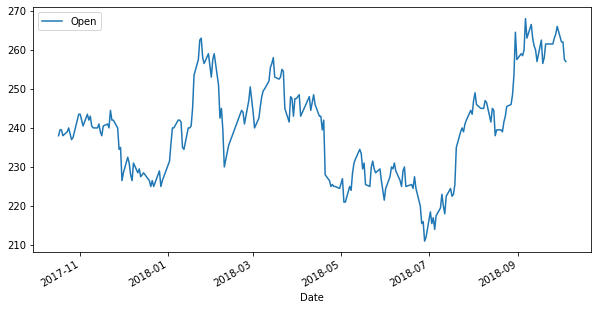

In [32]:
plt.rcParams['figure.figsize'] = (10, 5)

data.set_index('Date')[['Open']].plot()

    短期均線：window_short = 10
    長期均線：window_long = 35
    偏離度閾值：SD = 0.5%，區間寬度

In [102]:
window_short = 10
window_long = 35
SD = 0.005

data['short_window'] = np.round(data['Open'].rolling(window=window_short).mean(), 2)
data['long_window'] = np.round(data['Open'].rolling(window=window_long).mean(), 2)
data[['Open', 'short_window', 'long_window']].tail()

,Open,short_window,long_window
331,266.0,261.15,254.40
558,262.0,261.65,254.84
804,262.0,261.60,255.43
40,257.5,261.70,255.79
269,257.0,261.60,256.14


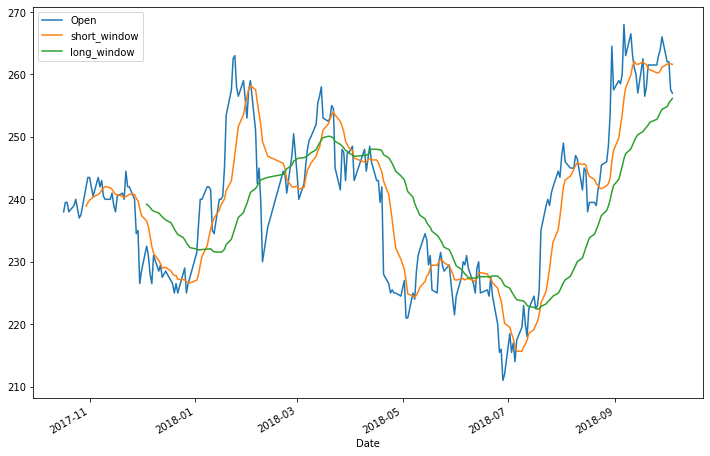

In [103]:
data.set_index('Date')[['Open', 'short_window', 'long_window']].plot( figsize=(12,8))

    買入信號：短期均線高於長期日均線，並且超過SD個點位；
    賣出信號： 不滿足買入信號的所有情況；

    我們首先計算短期均線與長期均線的差s-l

In [99]:
data['s-l'] = data['short_window'] - data['long_window']
data['s-l'].tail()

331    6.75
558    6.81
804    6.17
40     5.91
269    5.46
Name: s-l, dtype: float64

    s−l>SD×long_window，支持買入，定義signal為1
    其他情形下，賣出信號，定義signal為0

In [100]:
data['signal'] = np.where(data['s-l'] > data['long_window'] * SD, 1, 0)

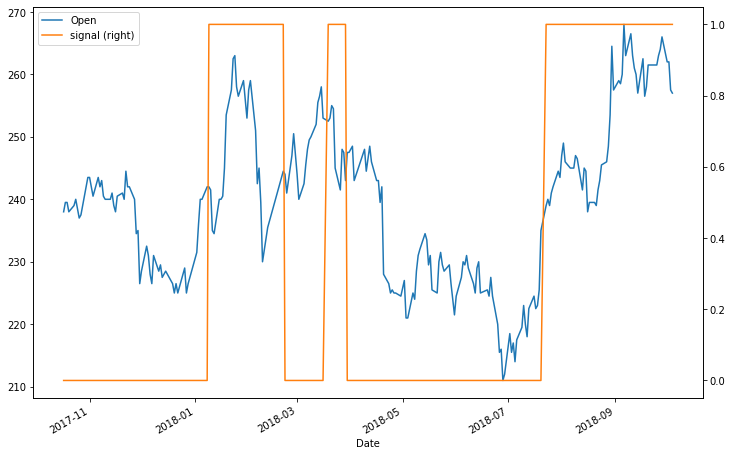

In [104]:
data.set_index('Date')[['Open', 'signal']].plot( figsize=(12,8) ,secondary_y='signal')

# 轉成log 方便把每日獲利加起來

In [105]:
data['Market'] = np.log(data['Open'] / data['Open'].shift(1))
data['Strategy'] = data['signal'].shift(1) * data['Market']
data[['Market', 'Strategy', 'signal']].tail()

,Market,Strategy,signal
331,0.007547,0.007547,1
558,-0.015152,-0.015152,1
804,0.000000,0.000000,1
40,-0.017325,-0.017325,1
269,-0.001944,-0.001944,1


In [106]:
data[['Market', 'Strategy']].cumsum().apply(np.exp)

,Market,Strategy
482,NaN,NaN
753,1.006303,1.000000
21,1.006303,1.000000
290,1.000000,1.000000
561,1.004202,1.000000
...,...,...
331,1.117647,1.099948
558,1.100840,1.083407
804,1.100840,1.083407
40,1.081933,1.064799


可以看最後累積的獲利,策略輸給放著不動

買著不動
1.079832	

策略
1.062731

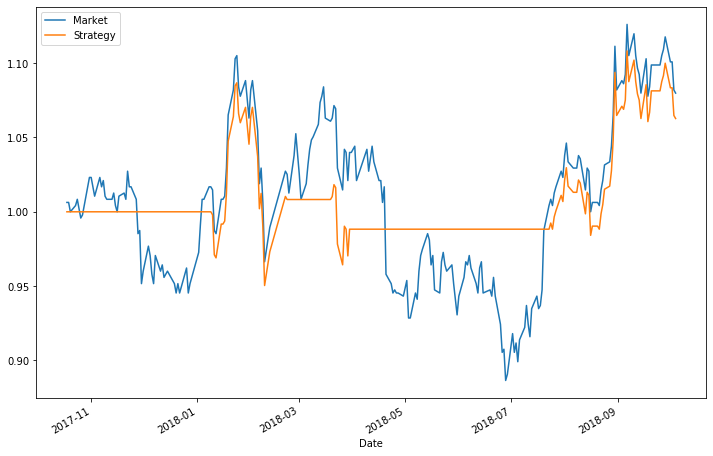

In [108]:
data.set_index('Date')[['Market', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(12,8))

# 使用策略比沒有策略賺的還少

# 使用 hyperopt 最佳化  window_short = 10 、window_long = 35、SD = 0.5% 這三個參數


In [135]:
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

def hyperopt_model_score(params):
    
    window_short = int(params['window_short'])
    window_long = int(params['window_long'])
    SD = params['SD']

    data['short_window'] = np.round(data['Open'].rolling(window=window_short).mean(), 2)
    data['long_window'] = np.round(data['Open'].rolling(window=window_long).mean(), 2)
    data['s-l'] = data['short_window'] - data['long_window']
    data['signal'] = np.where(data['s-l'] > data['long_window'] * SD, 1, 0)
    
    data['Market'] = np.log(data['Open'] / data['Open'].shift(1))
    data['Strategy'] = data['signal'].shift(1) * data['Market']
    
    return np.exp(data['Strategy'].sum())


space = {
        'window_short': hp.quniform('window_short', 3, 20 ,1),
        'window_long': hp.quniform('window_long', 30, 90 ,1),
        'SD': hp.loguniform('SD', np.log(0.0001), np.log(0.01)),
}

def fn_dtree(params):
    acc = hyperopt_model_score(params)
    return -acc


trials = Trials()
best = fmin(
    fn=fn_dtree, space=space, algo=tpe.suggest, max_evals=600, trials=trials)
print('best:')
print(best)



100%|█████████████████████████████████████████████| 600/600 [00:16<00:00, 36.39trial/s, best loss: -1.1395116467869852]
best:
{'SD': 0.0003897670349112452, 'window_long': 63.0, 'window_short': 8.0}



    hp.choice返回一個選項，選項可以是list或者tuple.options可以是嵌套的表達式，用於組成條件參數。
    hp.pchoice(label,p_options)以一定的概率返回一個p_options的一個選項。這個選項使得函數在搜索過程中對每個選項的可能性不均勻。
    hp.uniform(label,low,high)參數在low和high之間均勻分佈。
    hp.quniform(label,low,high,q),參數的取值是round(uniform(low,high)/q)*q，適用於那些離散的取值。
    hp.loguniform(label,low,high)繪製exp(uniform(low,high)),變量的取值範圍是[exp(low),exp(high)]
    hp.randint(label,upper) 返回一個在[0,upper)前閉後開的區間內的隨機整數。

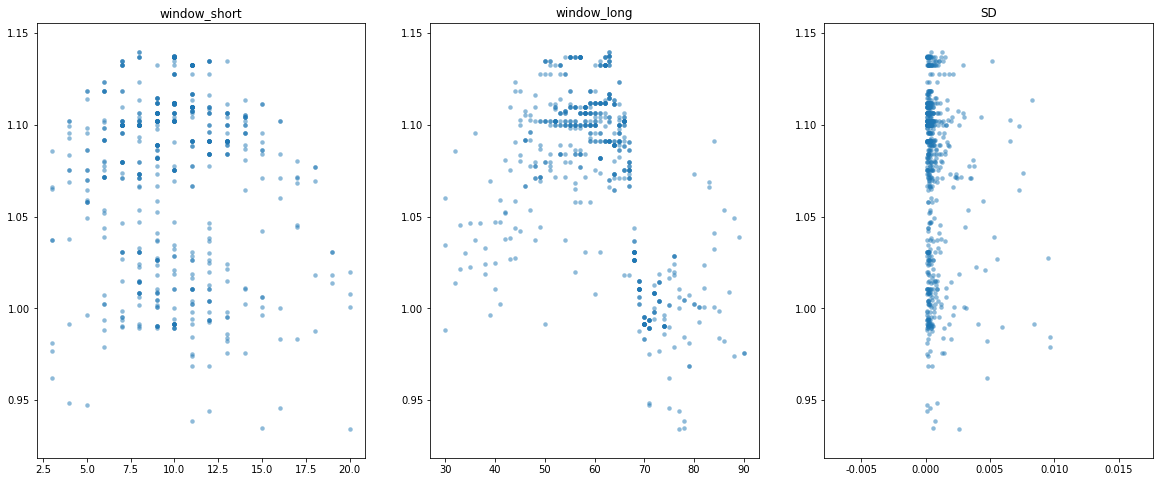

In [136]:
parameters = ["window_short", "window_long","SD"]

cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 8))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    ys = np.array(ys)
    axes[i].scatter(
        xs,
        ys,
        s=20,
        linewidth=0.01,
        alpha=0.5,
    )
    axes[i].set_title(val)

# 可以根據以上的圖調整參數範圍不斷優化

In [138]:
params={'SD': 0.0003897670349112452, 'window_long': 63.0, 'window_short': 8.0}
window_short = int(params['window_short'])
window_long = int(params['window_long'])
SD = params['SD']

data['short_window'] = np.round(data['Open'].rolling(window=window_short).mean(), 2)
data['long_window'] = np.round(data['Open'].rolling(window=window_long).mean(), 2)
data['s-l'] = data['short_window'] - data['long_window']
data['signal'] = np.where(data['s-l'] > data['long_window'] * SD, 1, 0)

data['Market'] = np.log(data['Open'] / data['Open'].shift(1))
data['Strategy'] = data['signal'].shift(1) * data['Market']

np.exp(data['Strategy'].sum())

1.1395116467869852

In [152]:
np.exp(data['Market'].sum())

1.0798319327731083


優化過的策略，優於持續抱股很多

買著不動 1.079832

策略 1.1395116467869852

In [145]:
data_plot=data.set_index('Date')[['Market', 'Strategy']].cumsum().apply(np.exp)

In [149]:
data_plot['signal']=data.set_index('Date')['signal']

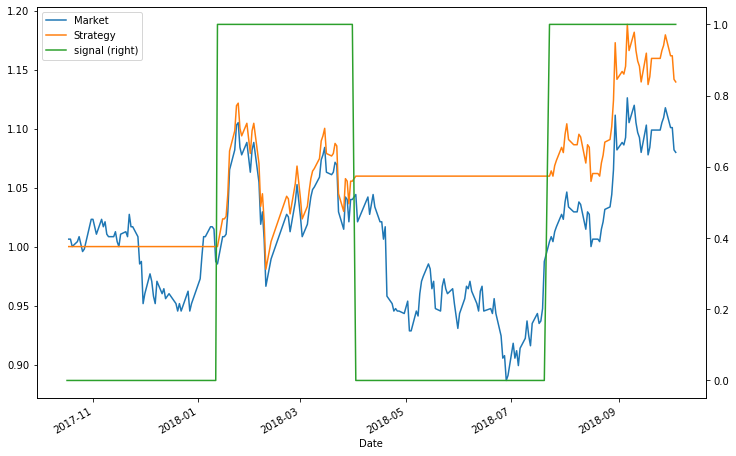

In [151]:
data_plot[['Market', 'Strategy','signal']].plot(figsize=(12,8) ,secondary_y='signal')

# 這個策略未來使用的情況

In [153]:
data=test[ test['StockNo']=='2330']

params={'SD': 0.0003897670349112452, 'window_long': 63.0, 'window_short': 8.0}
window_short = int(params['window_short'])
window_long = int(params['window_long'])
SD = params['SD']

data['short_window'] = np.round(data['Open'].rolling(window=window_short).mean(), 2)
data['long_window'] = np.round(data['Open'].rolling(window=window_long).mean(), 2)
data['s-l'] = data['short_window'] - data['long_window']
data['signal'] = np.where(data['s-l'] > data['long_window'] * SD, 1, 0)

data['Market'] = np.log(data['Open'] / data['Open'].shift(1))
data['Strategy'] = data['signal'].shift(1) * data['Market']

np.exp(data['Strategy'].sum())

1.2891102616574637

In [156]:
print('什麼都不做優於策略')
np.exp(data['Market'].sum())

什麼都不做優於策略


1.2933884297520666

    2330在
    2017/10/04  ~ 2018/10/04
    的最佳策略

    使用同樣策略在
    2019/06/20~ 2020/06/12
    輸給持續抱股

# 所有策略都可以在回測中找到最佳參數，因為雙均線策略本身就沒有什麼用處，個人認為幾乎所有技術指標都不太有用，但如果發現一個合理的策略，可以用hyperopt來最佳化他